# RBF version 


Lets define the RBF network

In [62]:
import pandas as pd
import scipy
import numpy as np
from sklearn.model_selection import train_test_split
# grid search, K-fold validation, fix seed
# find the model, but save the test loss and train loss for all the tried models
# create plot over parameter values and losses
import time

In [63]:
data = pd.read_csv('DATA (1).csv')
X_train, X_test, y_train, y_test = train_test_split(data[['x1','x2']], data[['y']], test_size=0.255, random_state=1990243)

In [64]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_tr = y_train.to_numpy()
y_te = y_test.to_numpy()

In [65]:
mat1 = np.random.normal(size=(2,4,2)) 
mat2 = np.array([[0,3],[1,2]])
res = (np.tile(mat2,(4,1)).reshape((2,4,2)))
print(np.linalg.norm(mat1, axis=-1))

[[2.27634365 1.5056245  1.63685736 0.71664706]
 [1.41152679 1.75419945 0.2023436  1.25431312]]


In [66]:
# sigma is a RBF spread parameter and simga > 0
def Gaussian(X, sigma):
    return np.exp(-(np.linalg.norm(X,axis = -1)/sigma)**2)

In [67]:
def RBF(W, args):
    sigma = args[1]
    X = args[2]
    C = W[0]
    v = W[1]
    #print(v.shape, Gaussian(X-C,sigma).shape)
    return np.matmul(v,Gaussian(X-C, sigma).T) 

In [117]:
def loss(W, args):
    N = args[0]
    if args[-1] == 1:
        a = args[-2]
        v = W
    elif args[-1] == 2:
        v = args[-2]
        a = W.reshape(1,N,2) 
    else:
        v = W[-N:]
        a = W[:-N].reshape(1,N,2)

    y = args[3]
#    c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2)).T
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)

    regu = np.sum(a**2) + np.sum(v**2)
    loss = float((1/(2*len(args[2]))* np.sum((RBF((c,v), args) - y.T)**2, axis=1) + args[4]/2* regu)[0])
    #print(loss)
    return loss 

In [198]:
def grad_v(W, args):
    N = args[0]
    if args[-1] == 1:
        a = args[-2]
        v = W
    elif args[-1] == 2:
        v = args[-2]
        a = W.reshape(1,N,2) 
    else:
        v = W[-N:]
        a = W[:-N].reshape(1,N,2)

    y = args[3]
#    c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2)).T
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)
    phi = Gaussian(args[2]-c, args[1])
    grads = phi.T @ (phi @ v - y.reshape(-1)) + len(args[2])*args[4]*v
    return grads

In [ ]:
def grad_c(W, args):
    N = args[0]
    if args[-1] == 1:
        a = args[-2]
        v = W
    elif args[-1] == 2:
        v = args[-2]
        a = W.reshape(1,N,2) 
    else:
        v = W[-N:]
        a = W[:-N].reshape(1,N,2)

    y = args[3]
#    c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2)).T
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)
    phi = Gaussian(args[2]-c, args[1])
    grads = phi.T @ (phi @ v - y.reshape(-1)) + len(args[2])*args[4]*v
    return grads

In [85]:
def preproc(N, X_train, hold = False, seed = 123): #n: the nr of neurons; hold: if we want the centers to be chosen from X_train
    np.random.seed(seed)
    if hold == True:

       a = X_train[np.random.choice(np.arange(X_train.shape[0]), N, replace=False)].reshape(1,N,2) 
    else:
        a =  np.random.normal(size=(1, N, 2))
    #res = np.tile(X_train,(N,1)).reshape((X_train.shape[0],N,2))
    res = np.repeat(X_train,N,axis=0).reshape(X_train.shape[0],N,2)
    
    
    #C = np.repeat(a,X_train.shape[0], axis=1).reshape(X_train.shape[0],N,2)
    

    v = np.random.normal(size = N)
    return a,v,res # a:centers;v: weights; res: train data with compatible shape


In [86]:
def func(W, args): #for plotting
    N = args[0]
    v = W[-N:]
    a = W[:-N].reshape(1,N,2)
    #c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2))
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)


    return RBF((c,v), args)

In [87]:
def test_error(W,  args):
    N = args[0]
    v = W[-N:]
    a = W[:-N].reshape(1,N,2)
    y = args[3]
    #c = np.repeat(a,args[2].shape[0],axis=1).reshape((args[2].shape[0],N,2))
    c = np.tile(a,(args[2].shape[0],1)).reshape(args[2].shape[0],N,2)


    return float((1/(2*len(args[2]))* np.sum((RBF((c,v), args) - y.T)**2, axis=1)))

In [180]:
a = np.array([[1,2],[1,2],[1,2]])
b = np.array([1,2])
print(a.shape, b.shape)
np.matmul(a,b)

(3, 2) (2,)


array([5, 5, 5])

In [202]:
## main loop
rho = 1e-3
sigma =0.5 
N = 50 
seed = 123 #seed for weight initializtion
met = 'CG'
testing = 2 #which task are we testing

if testing == 1:
    C,V,res = preproc(N, X_train, seed= seed)
    print(len(res))
    shape = C.shape
    args = (N,sigma, res, y_tr, rho, shape,None, 0) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = np.append(C.flatten(),V)
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,) , method=met, options = {"maxiter": 500})
elif testing == 2:
    C,V,res = preproc(N, X_train, 1, seed=seed)
    shape = C.shape
    args = (N,sigma, res, y_tr, rho, shape,C, 1) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = V 
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,),jac=grad_v,  method=met)#, options = {"maxiter": 5})
else:
    C,V,res = preproc(N, X_train, 1, seed = seed)
    shape = C.shape
    args = (N,sigma, res, y_tr, rho, shape,C, 1) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = V 
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,) , method=met)#, options = {"maxiter": 5})
    print(result_rbf)
    args = (N,sigma, res, y_tr, rho, shape,result_rbf.x, 2) #three modes: 0: both supervised; 1: centers unsupervised; 2:weights v unsupervised
    W = C
    print(loss(W, args))
    result_rbf = scipy.optimize.minimize(loss, W, args= (args,) , method=met)#, options = {"maxiter": 5})
print(result_rbf)




1.3449853393709228
     fun: 0.22656124103456926
     jac: array([-3.37566294e-07, -1.18933983e-06, -3.18883372e-06, -3.45831378e-06,
       -3.88465962e-07,  7.55615711e-07,  7.06336432e-06, -2.14919559e-06,
        1.38448839e-06,  7.40408631e-08, -8.89464352e-06,  2.66899967e-06,
       -2.36644429e-06,  5.31573273e-08, -7.78397609e-07,  4.92960818e-06,
        7.87040800e-07, -1.47719032e-06, -6.16365602e-06, -5.41691442e-06,
        1.78281057e-07,  1.32521703e-06,  5.97141135e-06, -6.39231447e-06,
        5.91412514e-06, -1.16442322e-06,  1.51411385e-06, -9.72244441e-06,
       -2.15794776e-06,  2.08362237e-06, -3.14953601e-06,  4.98143421e-06,
        3.22527980e-06, -2.23854132e-06, -7.01484187e-06,  3.27621391e-06,
       -2.35098050e-06,  7.00646719e-07, -8.20334113e-06,  3.61000899e-07,
       -4.62317157e-06, -7.06543033e-07, -4.02309822e-07, -2.84947519e-06,
       -6.97917396e-06,  1.81218434e-06, -9.36402262e-06,  7.39163746e-07,
       -3.54606258e-06, -2.42641990e-06])

In [139]:
print(result_rbf)

      fun: 1.3449853393737055
 hess_inv: <50x50 LbfgsInvHessProduct with dtype=float64>
      jac: array([87.76782551, 87.26061999, 87.48669387, 87.91453305, 88.05177791,
       87.78299826, 87.25856295, 88.8595486 , 88.22459229, 88.24171353,
       87.89605894, 87.81225761, 87.73566112, 88.00554574, 87.56155661,
       88.27501971, 88.3298744 , 87.33051747, 88.00817194, 87.5428656 ,
       88.01527699, 88.15745158, 87.04611966, 87.07428714, 88.03079112,
       88.52067875, 87.93834257, 87.52422939, 87.63708733, 88.31879177,
       87.91029307, 87.93902325, 88.53414172, 88.06516315, 87.74572123,
       87.42453011, 88.56880481, 87.01888946, 87.76576544, 87.73824923,
       87.80930128, 88.45623893, 88.18917301, 87.90774104, 87.28587608,
       88.0327641 , 87.51984815, 88.49885914, 87.85768732, 87.87381422])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 21
      nit: 0
     njev: 21
   status: 2
  success: False
        x: array([-0.23590284, -1.41195749, -0.88776123,  0.10426

In [203]:
###testing settings:
a,b, data_x = preproc(N,X_test)
data_y = y_te 
if testing == 2:
    W = np.append(C, result_rbf.x)
elif testing == 1:
    W = result_rbf.x
else:
    W = np.append(result_rbf.x, args[-2])

args = (N, sigma, data_x, data_y, rho, shape)
ter = test_error(W, args)
print(ter)

0.13037709907863226


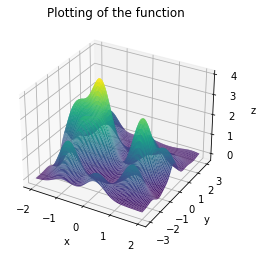

In [197]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 

def plotting( title='Plotting of the function'): #if you do not provide a title, 'Plotting...' will be used
    #create the object
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    n = 100
    #create the grid
    x = np.linspace(-2, 2, n) #create 50 points between [-5,5] evenly spaced  
    y = np.linspace(-3, 3, n)
    X, Y = np.meshgrid(x, y) #create the grid for the plot
    mixed =  np.vstack((X.flatten(),Y.flatten())).T
    a,b,res = preproc(N,mixed)
    Z = func(W, (N, sigma,res,y_tr,rho ))#evaluate the function (note that X,Y,Z are matrix)
    Z = Z.reshape((n,n))
    #print(Z.shape)


    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)
    plt.show()

plotting()